In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
# Loaded raw IMDB dataset (downloaded from Kaggle)
df = pd.read_csv("IMDB Dataset.csv")

In [3]:
# Encode labels
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [16]:
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(
    df['review'], df['label'], test_size=0.2, random_state=42
)

print("Training label distribution:\n", y_train.value_counts(), "\n")
print("Test label distribution:\n", y_test.value_counts(), "\n")

Training label distribution:
 label
0    20039
1    19961
Name: count, dtype: int64 

Test label distribution:
 label
1    5039
0    4961
Name: count, dtype: int64 



In [5]:
# Tokenize text
num_words = 10000
maxlen = 200

tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

x_train_pad = pad_sequences(x_train_seq, maxlen=maxlen)
x_test_pad = pad_sequences(x_test_seq, maxlen=maxlen)

In [8]:
# Build model with dropout
model = Sequential([
    Embedding(input_dim=num_words, output_dim=64),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [9]:
# Train model
history = model.fit(x_train_pad, y_train, epochs=3, batch_size=64, validation_split=0.2)

Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.7048 - loss: 0.5429 - val_accuracy: 0.8570 - val_loss: 0.3511
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - accuracy: 0.8556 - loss: 0.3557 - val_accuracy: 0.8568 - val_loss: 0.3429
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.8767 - loss: 0.3138 - val_accuracy: 0.8516 - val_loss: 0.3526


In [10]:
# Evaluate
loss, acc = model.evaluate(x_test_pad, y_test, verbose=2)
print(f"Test Accuracy: {acc:.2f}")

313/313 - 3s - 11ms/step - accuracy: 0.8598 - loss: 0.3421
Test Accuracy: 0.86


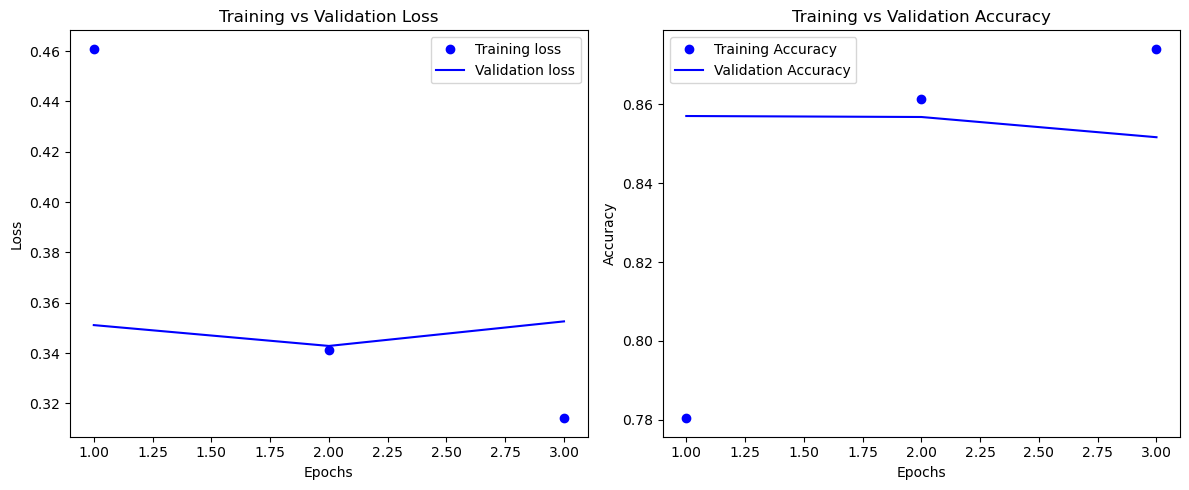

In [13]:
# Visualization - Training History
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training Accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


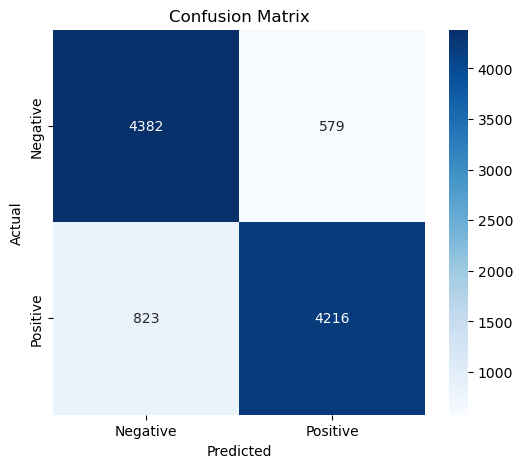


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4961
           1       0.88      0.84      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [14]:
# Confusion Matrix
y_pred_probs = model.predict(x_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [15]:
# Custom Reviews Prediction
def encode_text(text, tokenizer, maxlen=maxlen):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=maxlen)
    return padded

custom_reviews = [
    "This movie was absolutely fantastic! I loved every minute of it.",  
    "The film was boring and a complete waste of time.",                 
    "An average movie with some good moments but weak story.",          
    "Terrible acting, horrible plot. I hated it.",                       
    "One of the best movies I’ve seen in years. Brilliant story!",       
    "I wouldn’t recommend this movie to anyone. Really bad.",            
]

for review in custom_reviews:
    encoded_review = encode_text(review, tokenizer)
    prob = model.predict(encoded_review)[0][0]
    label = "Positive" if prob > 0.5 else "Negative"
    print(f"\nReview: {review}")
    print(f"Prediction: {label} ({prob:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Review: This movie was absolutely fantastic! I loved every minute of it.
Prediction: Positive (0.9240)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Review: The film was boring and a complete waste of time.
Prediction: Negative (0.0143)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Review: An average movie with some good moments but weak story.
Prediction: Negative (0.2234)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Review: Terrible acting, horrible plot. I hated it.
Prediction: Negative (0.0183)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Review: One of the best movies I’ve seen in years. Brilliant story!
Prediction: Positive (0.9333)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Review: I wouldn’t recommend this movie to anyone. Really bad.
Prediction: Negative (0.3530)
